# Convolutional Neural Networks

In the previous section, we built and trained a simple model to classify ASL images. The model was able to learn how to correctly classify the training dataset with very high accuracy, but, it did not perform nearly as well on validation dataset. This behavior of not generalizing well to non-training data is called [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), and in this section, we will introduce a popular kind of model called a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that is especially good for reading images and classifying them.

## Objectives

* Prep data specifically for a CNN
* Create a more sophisticated CNN model, understanding a greater variety of model layers
* Train a CNN model and observe its performance

## Loading and Preparing the Data

The below cell contains the data preprocessing techniques we learned in the previous labs. Review it and execute it before moving on:

In [1]:
#TimeStamp: Siangling Hsu 10/1/2022 12:00PM
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("/Users/siang-linghsu/Downloads/SianglingHsu Nvidia1 2/sign_mnist_train.csv")
valid_df = pd.read_csv("/Users/siang-linghsu/Downloads/SianglingHsu Nvidia1 2/sign_mnist_test.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 25
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

## Reshaping Images for a CNN

In the last exercise, the individual pictures in our dataset are in the format of long lists of 784 pixels:

In [2]:
x_train.shape, x_valid.shape

((27455, 784), (7172, 784))

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's reshape our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(27455, 784)` to `(27455, 28, 28, 1)`. As a convenience, we can pass the [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy.reshape) method a `-1` for any dimension we wish to remain the same, therefore:

In [3]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [4]:
x_train.shape

(27455, 28, 28, 1)

In [5]:
x_valid.shape

(7172, 28, 28, 1)

In [6]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

## Creating a Convolutional Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)
```
75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image. 

### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/). 

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

We have seen dense layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

Here, we summarize the model we just created. Notice how it has fewer trainable parameters than the model in the previous notebook:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

## Compiling the Model

We'll compile the model just like before:

In [9]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer = 'sgd')

## Training the Model

Despite the very different model architecture, the training looks exactly the same. Run the cell below to train for 20 epochs and let's see if the accuracy improves:

In [10]:
history = model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/10


2023-02-27 11:40:18.032331: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


858/858 [==============================] - 21s 24ms/step - loss: 0.8685 - accuracy: 0.7451 - val_loss: 0.4070 - val_accuracy: 0.8876
Epoch 2/10
858/858 [==============================] - 20s 24ms/step - loss: 0.1023 - accuracy: 0.9756 - val_loss: 0.2303 - val_accuracy: 0.9377
Epoch 3/10
858/858 [==============================] - 19s 22ms/step - loss: 0.0392 - accuracy: 0.9929 - val_loss: 0.1641 - val_accuracy: 0.9476
Epoch 4/10
858/858 [==============================] - 20s 23ms/step - loss: 0.0217 - accuracy: 0.9965 - val_loss: 0.2994 - val_accuracy: 0.8986
Epoch 5/10
858/858 [==============================] - 22s 25ms/step - loss: 0.0162 - accuracy: 0.9975 - val_loss: 0.1593 - val_accuracy: 0.9533
Epoch 6/10
858/858 [==============================] - 21s 25ms/step - loss: 0.0118 - accuracy: 0.9985 - val_loss: 0.1378 - val_accuracy: 0.9589
Epoch 7/10
858/858 [==============================] - 21s 25ms/step - loss: 0.0088 - accuracy: 0.9989 - val_loss: 0.1516 - val_accuracy: 0.9637
Epo

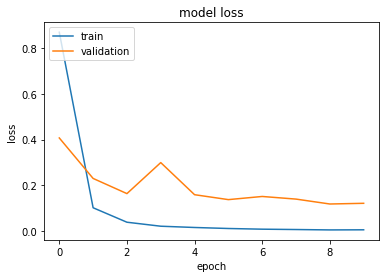

In [11]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Create Model 2 - increase the Dropout rate to solve the overfitting

In [12]:
model2 = Sequential()
model2.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2, 2), strides=2, padding="same"))
model2.add(Flatten())
model2.add(Dense(units=512, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(units=num_classes, activation="softmax"))

In [13]:
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"],optimizer='sgd')

In [14]:
history2 = model2.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/10
858/858 [==============================] - 21s 24ms/step - loss: 1.0999 - accuracy: 0.6570 - val_loss: 0.6352 - val_accuracy: 0.8316
Epoch 2/10
858/858 [==============================] - 23s 26ms/step - loss: 0.2392 - accuracy: 0.9245 - val_loss: 0.3638 - val_accuracy: 0.9258
Epoch 3/10
858/858 [==============================] - 23s 26ms/step - loss: 0.1213 - accuracy: 0.9628 - val_loss: 0.3786 - val_accuracy: 0.8581
Epoch 4/10
858/858 [==============================] - 23s 27ms/step - loss: 0.0767 - accuracy: 0.9777 - val_loss: 0.2005 - val_accuracy: 0.9438
Epoch 5/10
858/858 [==============================] - 24s 28ms/step - loss: 0.0541 - accuracy: 0.9849 - val_loss: 0.2482 - val_accuracy: 0.9320
Epoch 6/10
858/858 [==============================] - 23s 27ms/step - loss: 0.0433 - accuracy: 0.9878 - val_loss: 0.1396 - val_accuracy: 0.9603
Epoch 7/10
858/858 [==============================] - 21s 25ms/step - loss: 0.0327 - accuracy: 0.9916 - val_loss: 0.1975 - val_accuracy:

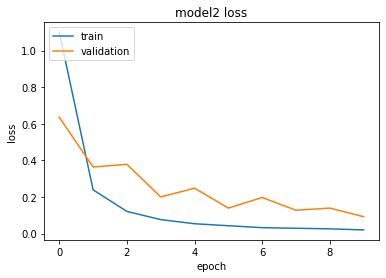

In [15]:

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Data Augmentation

So far, we've selected a model architecture that vastly improves the model's performance, as it is designed to recognize important features in the images. The validation accuracy is still lagging behind the training accuracy, which is a sign of overfitting: the model is getting confused by things it has not seen before when it tests against the validation dataset.

In order to teach our model to be more robust when looking at new data, we're going to programmatically increase the size and variance in our dataset. This is known as data augmentation, a useful technique for many deep learning applications.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.


Before compiling the model, it's time to set up our data augmentation.

Keras comes with an image augmentation class called ImageDataGenerator. We recommend checking out the documentation here. It accepts a series of options for augmenting your data. Later in the course, we'll have you select a proper augmentation strategy. For now, take a look at the options we've selected below, and then execute the cell to create an instance of the class:


Take a moment to think about why we would want to flip images horizontally, but not vertically. When you have an idea, reveal the text below.

Our dataset is pictures of hands signing the alphabet. If we want to use this model to classify hand images later, it's unlikely that those hands are going to be upside-down, but, they might be left-handed. This kind of domain-specific reasoning can help make good decisions for your own deep learning applications.



In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

## Batch Size

Another benefit of the ImageDataGenerator is that it batches our data so that our model can train on a random sample.

If the model is truly random, meaning that the data is properly shuffled so it's fair like a deck of cards, then our sample can do a good job of representing all of our data even though it is a tiny fraction of the population. For each step of the training, the model will be dealt a new batch.

In practice, a batch size of 32 and 64 does well. Run the cell below to see what kind of batches we'll be training our model with. Is our randomizer fairly randomizing? Are all of the images recognizable ASL letters?

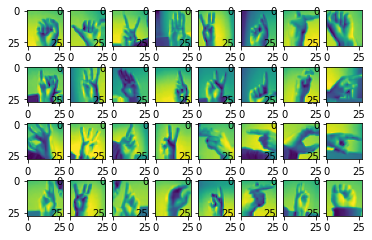

In [17]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Fitting the Data to the Generator
Next, the generator must be fit on the training dataset.

In [18]:
datagen.fit(x_train)

## Compiling the Model
With the data generator instance created and fit to the training data, the model can now be compiled in the same way as our earlier examples:


In [19]:
model3 = Sequential()
model3.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model3.add(Dropout(0.3))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model3.add(Dropout(0.3))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Flatten())
model3.add(Dense(units=512, activation="relu"))
model3.add(Dropout(0.3))
model3.add(Dense(units=num_classes, activation="softmax"))

In [20]:
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer = 'sgd')

## Training with Augmentation
When using an image data generator with Keras, a model trains a bit differently: instead of just passing the x_train and y_train datasets into the model, we pass the generator in, calling the generator's flow method. This causes the images to get augmented live and in memory right before they are passed into the model for training.

Generators can supply an indefinite amount of data, and when we use them to train our data, we need to explicitly set how long we want each epoch to run, or else the epoch will go on indefinitely, with the generator creating an indefinite number of augmented images to provide the model.

We explicitly set how long we want each epoch to run using the steps_per_epoch named argument. Because steps * batch_size = number_of_images_trained in an epoch a common practice, that we will use here, is to set the number of steps equal to the non-augmented dataset size divided by the batch_size (which has a default value of 32).

Run the following cell to see the results. The training will take longer than before, which makes sense given we are now training on more data than previously:



In [21]:
history3 = model3.fit(img_iter,
          epochs=10,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/10
857/857 [==============================] - 22s 25ms/step - loss: 2.2756 - accuracy: 0.2991 - val_loss: 1.6895 - val_accuracy: 0.4716
Epoch 2/10
857/857 [==============================] - 21s 25ms/step - loss: 1.2455 - accuracy: 0.5790 - val_loss: 0.8789 - val_accuracy: 0.7271
Epoch 3/10
857/857 [==============================] - 21s 25ms/step - loss: 0.8623 - accuracy: 0.7008 - val_loss: 0.5400 - val_accuracy: 0.8673
Epoch 4/10
857/857 [==============================] - 22s 26ms/step - loss: 0.6468 - accuracy: 0.7746 - val_loss: 1.1861 - val_accuracy: 0.5987
Epoch 5/10
857/857 [==============================] - 22s 25ms/step - loss: 0.5184 - accuracy: 0.8202 - val_loss: 0.5465 - val_accuracy: 0.8168
Epoch 6/10
857/857 [==============================] - 22s 25ms/step - loss: 0.4345 - accuracy: 0.8506 - val_loss: 0.2938 - val_accuracy: 0.9248
Epoch 7/10
857/857 [==============================] - 21s 25ms/step - loss: 0.3652 - accuracy: 0.8754 - val_loss: 0.2678 - val_accuracy:

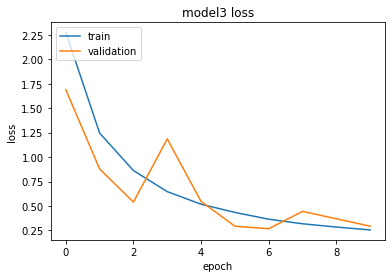

In [22]:

# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()